In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm import tqdm

plt.style.use("../config/custom_plt.mplstyle")

In [2]:
labels = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora.content", 
                     sep="\t", header=None)
labels.columns = ['id', *[f'f{i}' for i in range(1433)], 'label']

labels = labels[['id', 'label']]
labels.head()

,id,label
0,31336,Neural_Networks
1,1061127,Rule_Learning
2,1106406,Reinforcement_Learning
3,13195,Reinforcement_Learning
4,37879,Probabilistic_Methods


In [3]:
categories = labels['label'].unique()
colormap = cm.get_cmap('Set1', len(categories))

/tmp/ipykernel_3516648/3370728750.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Set1', len(categories))


In [4]:
category_to_colormap = dict(zip(categories, range(len(categories))))
category_to_colormap

{'Neural_Networks': 0,
 'Rule_Learning': 1,
 'Reinforcement_Learning': 2,
 'Probabilistic_Methods': 3,
 'Theory': 4,
 'Genetic_Algorithms': 5,
 'Case_Based': 6}

## Exploring node features

In [5]:
from sklearn.metrics.pairwise import *

features = pd.read_csv("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora.content", 
                     sep="\t", header=None)
features.columns = ['id', *[f'f{i}' for i in range(1433)], 'label']
features.drop('label', axis=1, inplace=True)
features.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1423,f1424,f1425,f1426,f1427,f1428,f1429,f1430,f1431,f1432
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1061127,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
import networkx as nx

g = nx.read_edgelist("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/cora_GC.edge")
gcc_edges_idx = list(g.nodes)

gcc_edges_idx.sort()
gcc_edges_idx[:5]

['1000012', '100197', '100701', '100935', '100961']

In [7]:
data = features.merge(labels, on="id")
data.id = data.id.astype(str)
data = data[data.id.isin(gcc_edges_idx)] # Only take GCC

data

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f1424,f1425,f1426,f1427,f1428,f1429,f1430,f1431,f1432,label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,1128975,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2704,1128977,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2705,1128978,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Genetic_Algorithms
2706,117328,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Case_Based


## Dimensional reduction of the nodes' features using UMAP

In [8]:
from sklearn import preprocessing
from sklearn.utils import shuffle


X = data.drop(["id", "label"], axis=1).values

#y = data['label'].values
le = preprocessing.LabelEncoder()
y = le.fit_transform(data['label'].values)

X[:5], y[:5]

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([2, 5, 4, 4, 3]))

In [17]:
X.sum(axis=0).shape

(1433,)

In [9]:
%%time
from sklearn.model_selection import train_test_split
from umap.umap_ import UMAP
np.random.seed(12)

reducer = UMAP(metric='cosine', random_state=61)

X_umap = reducer.fit_transform(X)
X_umap.shape

CPU times: user 25.6 s, sys: 1.75 s, total: 27.3 s
Wall time: 35 s


(2485, 2)

Text(0.5, 1.0, 'UMAP dim=2')

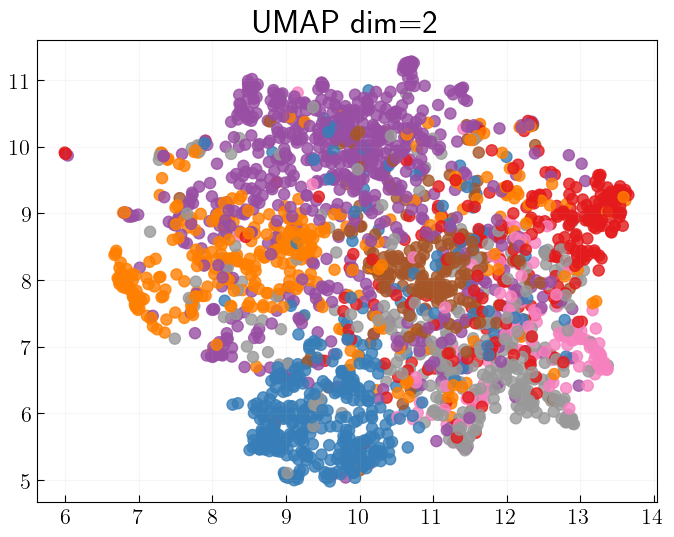

In [10]:
from matplotlib.lines import Line2D

plt.scatter(X_umap[:, 0], X_umap[:, 1], color=[colormap(i) for i in y], alpha=0.8)
plt.title('UMAP dim=2')

### Check non-euclidean embeddings

https://umap-learn.readthedocs.io/en/latest/embedding_space.html

**Spherical embeddings**

In [11]:
sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=61).fit(X) 

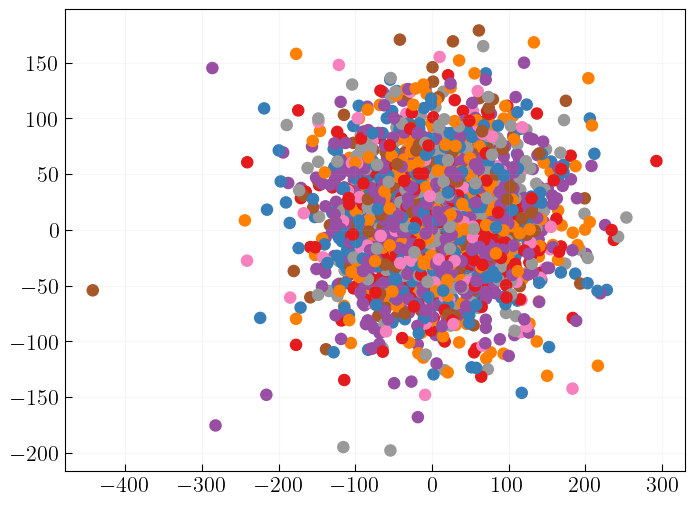

In [12]:
plt.scatter(sphere_mapper.embedding_.T[0], sphere_mapper.embedding_.T[1], c=[colormap(i) for i in y])

In [13]:
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])

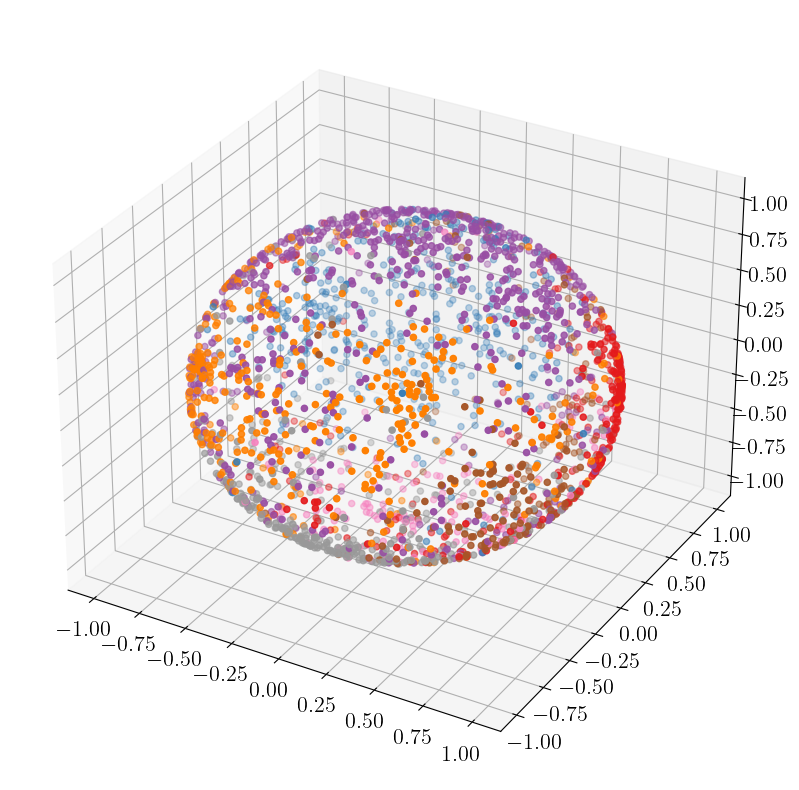

In [14]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx, yy, zz, c=[colormap(i) for i in y])

In [15]:
vectors = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

In [16]:
idx = data['id'].values
idx
# np.c_[idx, vectors]

array(['31336', '1061127', '1106406', ..., '1128978', '117328', '24043'],
      dtype=object)

In [17]:
vectors

array([[-0.15514302, -0.7251129 ,  0.67092615],
       [ 0.50277615,  0.6592991 , -0.55905354],
       [ 0.8524038 , -0.5197593 , -0.05707924],
       ...,
       [-0.528042  ,  0.7874458 , -0.31796324],
       [ 0.9729442 , -0.09234034,  0.21178521],
       [ 0.6098343 ,  0.15273336,  0.7776725 ]], dtype=float32)

In [18]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/cora/umap/only_gcc/umap_cora_spherical_positions_only_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [19]:
# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/cora/umap/all/umap_cora_spherical_positions_all.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [20]:
# For F-Mercator


# with open("/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/umap_cora_spherical_positions_gcc.txt", 'w') as f:
#     for i, v in zip(idx, vectors):
#         f.write(f'{i} {" ".join(map(str, v))}\n')

In [35]:
%%time

sphere_mapper = UMAP(metric='cosine', output_metric='haversine', random_state=2).fit(X)
xx = np.sin(sphere_mapper.embedding_[:, 0]) * np.cos(sphere_mapper.embedding_[:, 1])
yy = np.sin(sphere_mapper.embedding_[:, 0]) * np.sin(sphere_mapper.embedding_[:, 1])
zz = np.cos(sphere_mapper.embedding_[:, 0])
vectors2 = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1), zz.reshape(-1, 1)), axis=1)

CPU times: user 30.1 s, sys: 813 ms, total: 30.9 s
Wall time: 34.5 s


100%|██████████| 2485/2485 [06:12<00:00,  6.67it/s]


The best Z-axis rotation angle:  0.1282282715750936


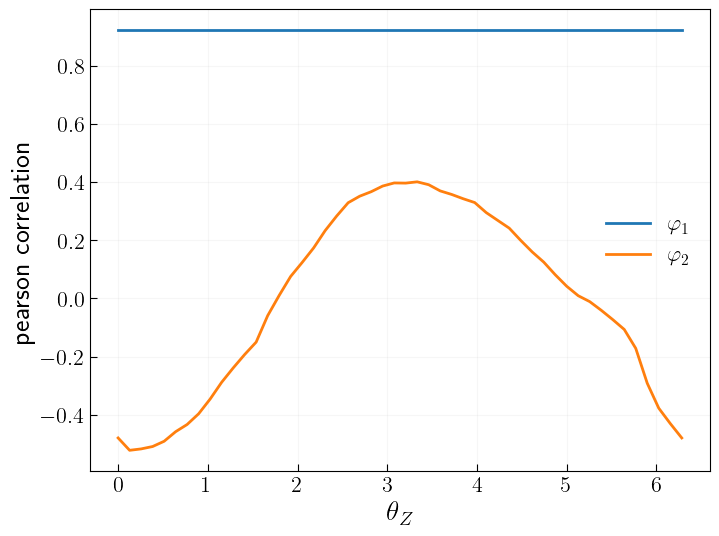

In [36]:
from lib.check_inferred_embeddings import *

real_coords_all, inf_coords_all, real_coords_spherical, inf_coords_spherical = \
    apply_pipeline_matrix_with_loading_and_rotate_all_euclidean_use_all_nodes(vectors, vectors2)

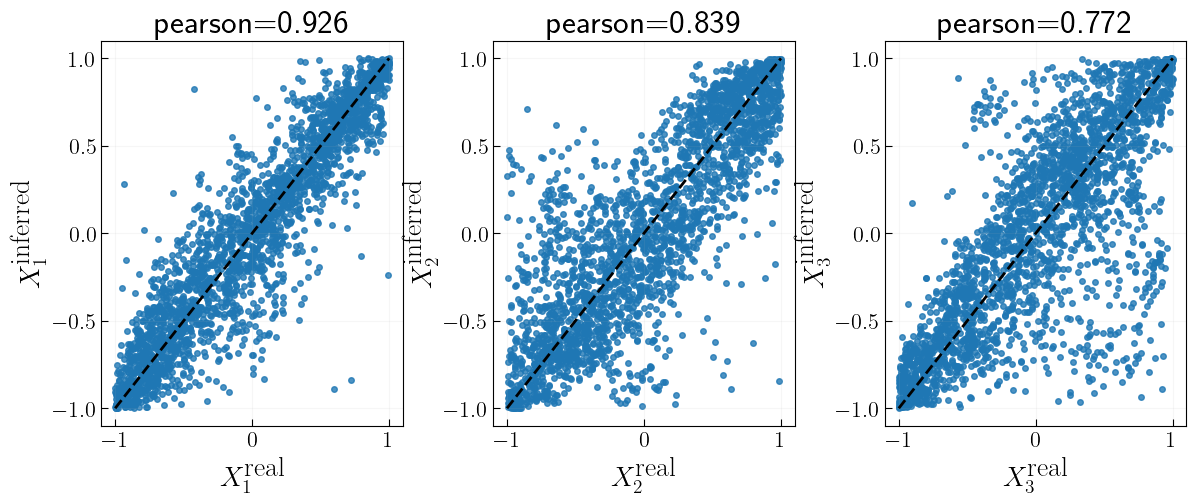

In [37]:
plot_euclidean_coordinates_comparison(inf_coords_all, real_coords_all)